# Backtesting ETH with backtrader

In [1]:
import backtrader as bt
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, DateFormatter
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

## Import data fast

In [2]:
import backtrader.feeds as btfeeds

data_feed_2 = btfeeds.GenericCSVData(
    dataname="/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_ETH_for_backtesting_IV.csv",
    #fromdate=datetime(2024, 1, 1), 
    #todate=datetime(2024, 5, 24),
    nullvalue=0.0,
    dtformat=('%Y-%m-%d'),
    datetime=0,
    high=2,
    low=3,
    open=1,
    close=4,
    volume=5,
    openinterest=8
)

Differently from the how_to file, now the changes are:
- commission from broker
- pnl of closed trades printed
- inserting some parameters in the strategy to have clear setup
- I print the final pnl and portfolio value directly in the stop function instead that outside

Since I am learning and this is a simple style notebook, I'll keep following the online quickstart from the documentation and will build much more complex things later.

In [19]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('exitbars', 5),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.cumulative_pnl = 0.0

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        self.cumulative_pnl += trade.pnl

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + self.params.exitbars):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
                
    def stop(self):
        self.log('Final Portfolio Value %.2f' % self.broker.getvalue())
        self.log('Cumulative PnL %.2f' % self.cumulative_pnl)

In [20]:
cerebro = bt.Cerebro(stdstats = False)
# Add a strategy
cerebro.addstrategy(TestStrategy, exitbars = 5)
cerebro.adddata(data_feed_2)

cerebro.broker.setcash(10000.0)
 # Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=2)
# Set the commission - 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.001)

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}') 
cerebro.run() 
print("End :)")
#print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 10000.00
2024-01-01, Close, 2355.55
2024-01-01, BUY CREATE, 2355.55
2024-01-02, BUY EXECUTED, Price: 2355.55, Cost: 4711.10, Comm 4.71
2024-01-02, Close, 2357.20
2024-01-03, Close, 2210.45
2024-01-04, Close, 2268.75
2024-01-05, Close, 2269.50
2024-01-06, Close, 2240.15
2024-01-07, Close, 2221.80
2024-01-07, SELL CREATE, 2221.80
2024-01-08, SELL EXECUTED, Price: 2221.80, Cost: 4711.10, Comm 4.44
2024-01-08, OPERATION PROFIT, GROSS -267.50, NET -276.65
2024-01-08, Close, 2331.50
2024-01-09, Close, 2343.70
2024-01-10, Close, 2584.85
2024-01-11, Close, 2619.80
2024-01-12, Close, 2521.15
2024-01-13, Close, 2577.45
2024-01-14, Close, 2472.60
2024-01-15, Close, 2510.60
2024-01-16, Close, 2586.05
2024-01-17, Close, 2528.30
2024-01-18, Close, 2468.80
2024-01-18, BUY CREATE, 2468.80
2024-01-19, BUY EXECUTED, Price: 2468.80, Cost: 4937.60, Comm 4.94
2024-01-19, Close, 2489.15
2024-01-20, Close, 2469.20
2024-01-21, Close, 2454.80
2024-01-22, Close, 2311.30
2024-01-23, Clo

Well this strategy for ETH sucks lol, ETH was 2k and later would be 3.7k, just hodling would have been fine of course.

But well if now we change the number of exitbars and reduce the time to sell...kinda to avoid messes and scalp a bit since it's basicalluy just going vertical all the time

In [21]:
cerebro = bt.Cerebro(stdstats = False)
# Add a strategy
cerebro.addstrategy(TestStrategy, exitbars = 2)
cerebro.adddata(data_feed_2)

cerebro.broker.setcash(10000.0)
 # Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=2)
# Set the commission - 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.001)

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}') 
cerebro.run() 
#print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')
print("End :)")

Starting Portfolio Value: 10000.00
2024-01-01, Close, 2355.55
2024-01-01, BUY CREATE, 2355.55
2024-01-02, BUY EXECUTED, Price: 2355.55, Cost: 4711.10, Comm 4.71
2024-01-02, Close, 2357.20
2024-01-03, Close, 2210.45
2024-01-04, Close, 2268.75
2024-01-04, SELL CREATE, 2268.75
2024-01-05, SELL EXECUTED, Price: 2268.75, Cost: 4711.10, Comm 4.54
2024-01-05, OPERATION PROFIT, GROSS -173.60, NET -182.85
2024-01-05, Close, 2269.50
2024-01-06, Close, 2240.15
2024-01-07, Close, 2221.80
2024-01-07, BUY CREATE, 2221.80
2024-01-08, BUY EXECUTED, Price: 2221.80, Cost: 4443.60, Comm 4.44
2024-01-08, Close, 2331.50
2024-01-09, Close, 2343.70
2024-01-10, Close, 2584.85
2024-01-10, SELL CREATE, 2584.85
2024-01-11, SELL EXECUTED, Price: 2584.85, Cost: 4443.60, Comm 5.17
2024-01-11, OPERATION PROFIT, GROSS 726.10, NET 716.49
2024-01-11, Close, 2619.80
2024-01-12, Close, 2521.15
2024-01-13, Close, 2577.45
2024-01-14, Close, 2472.60
2024-01-15, Close, 2510.60
2024-01-16, Close, 2586.05
2024-01-17, Close, 25

we getting rich pepe diamond hands. Probably there is an open position now.

## Let's add Indicators
Care that the strat will not work unless all indicators are computed

This strategy buys when the close price is above the 15 SMA and sells when it goes below it.
This is because are indicators declared in the init. I don't like this thing much but will face it later on.

In [3]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.cumulative_pnl = 0.0
        
        self.end_of_data = False

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)
        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        self.cumulative_pnl += trade.pnlcomm

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        try:
            self.dataclose[2]  # Try to access the next bar
            # Check if we are in the market
            if not self.position:

                # Not yet ... we MIGHT BUY if ...
                if self.dataclose[0] > self.sma[0]:

                    # BUY, BUY, BUY!!! (with all possible default parameters)
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()

            else:

                if self.dataclose[0] < self.sma[0]:
                    # SELL, SELL, SELL!!! (with all possible default parameters)
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.sell()
                
            # Check if the next bar exists
        
        #try:
        #    self.dataclose[2]  # Try to access the next bar
        except IndexError:
            if self.position:
                self.log('Final bar reached, closing position')
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell(exectype=bt.Order.Market)  # Ensure position is closed
                
    def stop(self):   
        self.log('Final Portfolio Value %.2f' % self.broker.getvalue())
        self.log('Cumulative PnL %.2f' % self.cumulative_pnl)

In [4]:
cerebro = bt.Cerebro() #(stdstats = False)this disables the 3 observers for the trades
# Add a strategy
cerebro.addstrategy(TestStrategy, maperiod = 15)
cerebro.adddata(data_feed_2)

cerebro.broker.setcash(10000.0)
 # Add a FixedSize sizer according to the stake *I wanna buy 2 ETH cauze I feel rich and not a poor student sigh...
cerebro.addsizer(bt.sizers.FixedSize, stake=2)
# Set the commission - 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.001)

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}') 
cerebro.run() 
#print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')
print("End :)")

Starting Portfolio Value: 10000.00
2024-02-03, Close, 2295.00
2024-02-04, Close, 2287.80
2024-02-05, Close, 2297.90
2024-02-05, BUY CREATE, 2297.90
2024-02-06, BUY EXECUTED, Price: 2297.90, Cost: 4595.80, Comm 4.60
2024-02-06, Close, 2370.85
2024-02-07, Close, 2423.00
2024-02-08, Close, 2419.05
2024-02-09, Close, 2486.80
2024-02-10, Close, 2500.75
2024-02-11, Close, 2506.90
2024-02-12, Close, 2660.30
2024-02-13, Close, 2641.10
2024-02-14, Close, 2778.50
2024-02-15, Close, 2826.50
2024-02-16, Close, 2805.30
2024-02-17, Close, 2789.20
2024-02-18, Close, 2884.10
2024-02-19, Close, 2947.15
2024-02-20, Close, 3018.95
2024-02-21, Close, 2971.80
2024-02-22, Close, 2970.70
2024-02-23, Close, 2922.70
2024-02-24, Close, 2994.05
2024-02-25, Close, 3115.55
2024-02-26, Close, 3180.60
2024-02-27, Close, 3245.50
2024-02-28, Close, 3389.00
2024-02-29, Close, 3344.95
2024-03-01, Close, 3438.55
2024-03-02, Close, 3427.50
2024-03-03, Close, 3493.25
2024-03-04, Close, 3634.10
2024-03-05, Close, 3562.20
20

Since we are in daily bars, I had to make sure to sell before the last day (it takes one day to complete the order in the daily). In this way The Cumulative PnL is verified as correct and I am happy.

So How I solved the problem here?
- check if there are at least 2 next bars
- if not close position now, which mean it gets closed on the last bar
- last bar has no position so nothing happens

This allows me to have a sure amount of PnL instead of living some shit ti the open position that may disrupt my account.

In [5]:
%matplotlib inline
cerebro.plot()

<IPython.core.display.Javascript object>

/Users/leonardoplacidi/opt/anaconda3/envs/BT/lib/python3.9/site-packages/backtrader/plot/locator.py:184: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 14.
  warnings.warn('AutoDateLocator was unable to pick an '


[[<Figure size 640x480 with 8 Axes>]]

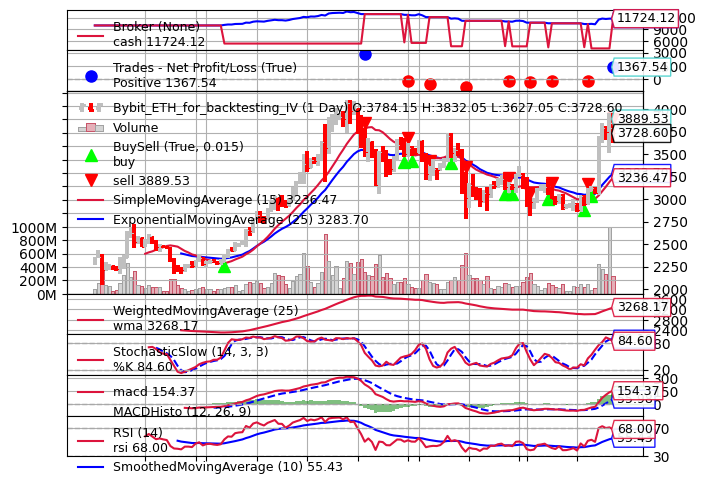

In [9]:
# Plotting
%matplotlib inline
fig = cerebro.plot(iplot=False)[0][0]

# Customize the x-axis date format
locator = AutoDateLocator()
formatter = DateFormatter('%Y-%m-%d')
ax = fig.get_axes()[0]  # Get the first (and only) axis
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
fig.autofmt_xdate()

plot_path = "/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/some_plots/eth.png"  # Replace with your desired folder path
fig.savefig(plot_path, bbox_inches='tight')

plt.show()

## Example to optimize a strategy (varying a parameter of interest)

I'll modify my own strategy to do:
1) not print logs
2) find most suitable sma

In [3]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
        ('printlog', False)
    )

    def log(self, txt, dt=None, doprint = False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.cumulative_pnl = 0.0
        
        self.end_of_data = False

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)
        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        self.cumulative_pnl += trade.pnlcomm

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        try:
            self.dataclose[2]  # Try to access the next bar
            # Check if we are in the market
            if not self.position:

                # Not yet ... we MIGHT BUY if ...
                if self.dataclose[0] > self.sma[0]:

                    # BUY, BUY, BUY!!! (with all possible default parameters)
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()

            else:

                if self.dataclose[0] < self.sma[0]:
                    # SELL, SELL, SELL!!! (with all possible default parameters)
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.sell()
                
            # Check if the next bar exists
        
        #try:
        #    self.dataclose[2]  # Try to access the next bar
        except IndexError:
            if self.position:
                self.log('Final bar reached, closing position')
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell(exectype=bt.Order.Market)  # Ensure position is closed
                
    def stop(self):   
        self.log("SMA period %d" % self.params.maperiod, doprint=True)
        self.log('Final Portfolio Value %.2f' % self.broker.getvalue(),  doprint=True)
        self.log('Cumulative PnL %.2f' % self.cumulative_pnl,  doprint=True)

In [5]:
cerebro = bt.Cerebro() #(stdstats = False)this disables the 3 observers for the trades
# Add a strategy
#cerebro.addstrategy(TestStrategy, maperiod = 15)

##optimize!
cerebro.optstrategy(
        TestStrategy,
        maperiod=range(10, 31))

cerebro.adddata(data_feed_2)

cerebro.broker.setcash(10000.0)
 # Add a FixedSize sizer according to the stake *I wanna buy 2 ETH cauze I feel rich and not a poor student sigh...
cerebro.addsizer(bt.sizers.FixedSize, stake=2)
# Set the commission - 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.001)

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}') 
cerebro.run(maxcpus=1) 
#print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')
print("End :)")

Starting Portfolio Value: 10000.00
2024-05-24, SMA period 10
2024-05-24, Final Portfolio Value 13213.14
2024-05-24, Cumulative PnL 3213.14
2024-05-24, SMA period 11
2024-05-24, Final Portfolio Value 12531.37
2024-05-24, Cumulative PnL 2531.37
2024-05-24, SMA period 12
2024-05-24, Final Portfolio Value 12423.66
2024-05-24, Cumulative PnL 2423.66
2024-05-24, SMA period 13
2024-05-24, Final Portfolio Value 12423.66
2024-05-24, Cumulative PnL 2423.66
2024-05-24, SMA period 14
2024-05-24, Final Portfolio Value 11759.66
2024-05-24, Cumulative PnL 1759.66
2024-05-24, SMA period 15
2024-05-24, Final Portfolio Value 11724.12
2024-05-24, Cumulative PnL 1724.12
2024-05-24, SMA period 16
2024-05-24, Final Portfolio Value 12529.15
2024-05-24, Cumulative PnL 2529.15
2024-05-24, SMA period 17
2024-05-24, Final Portfolio Value 11607.74
2024-05-24, Cumulative PnL 1607.74
2024-05-24, SMA period 18
2024-05-24, Final Portfolio Value 12062.08
2024-05-24, Cumulative PnL 2062.08
2024-05-24, SMA period 19
202

That's all for now, this is a simple strategy with decent setup on backtrader, more great things will come :)